# Alligator Analysis

Here we'll try to run some analyses on the alligator simulations.

- [x] Recover the original values (actual level of dimorphism)
- [x] See how the recovery value changes over the sample size
- [ ] See how the recovery does when you change the effect size

## Recovering Parameters from a Single Population

First, let's see if we can recover the population parameters for a single population.

In [1]:
library(ggplot2)
library(FSA) # for the vbStart function to find good parameters for the von Bertalanffy function
library(minpack.lm) # a more robust version of nls for non-linear curve fitting to avoid problems with e.g. very small sample sizes
library(rstan)

custom_theme <- function() {
  theme_minimal() +
    theme(
      panel.background = element_rect(fill = "white"),
      panel.grid.major = element_line(color = alpha("black", 0.5), linetype = "dotted", linewidth = 0.5),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 12),  # Adjust the font size of axis labels
      axis.title = element_text(size = 16),  # Adjust the font size of axis titles
      plot.title = element_text(size = 20, hjust = 0.5),  # Adjust the font size and center the plot title
      plot.subtitle = element_text(size = 16, hjust = 0.5)  # Adjust the font size and center the plot subtitle
    )
}
options(repr.plot.width=15, repr.plot.height=8)

# rstan options
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

## FSA v0.9.5. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.

Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
actual_male_params <- list(
    L = 3.79,
    A = 0.94,
    K = 0.0695
)
actual_female_params <- list(
    L = 2.78,
    A = 0.91,
    K = 0.0926
)

sigma_coefficient <- 0.0332
sigma_offset <- 0.046

generalized_von_bertalanffy <- function(age, L, A, K) {
    # print(paste("L", L))
    # print(paste("A", A))
    # print(paste("K", K))
    L * (1 - A * exp(-K * age))
}

generate_initial_vb_params <- function(df, debug = FALSE) {
    initial_params_raw <- tryCatch({vbStarts(df$length ~ df$age)},
        error = function(e) {
            if (debug) {
                cat("Error getting initial von Bertalanffy parameters for data", conditionMessage(e))
            }
            NULL
        }
    )

    if (is.null(initial_params_raw)) return(NULL)

    # now convert to my parameterization
    # I use y = Linf * (1 - A e ^ (-Kt) )
    # they use y = Linf * (1 - e^(-K (t - t0)))
    # -> A = e^K t0
    initial_params <- list(
        L = initial_params_raw$Linf,
        K = initial_params_raw$K,
        A = exp(initial_params_raw$K * initial_params_raw$t0)
    )
    initial_params
}

ALLIGATOR_MAX_LIFESPAN <- 50

In [3]:
generate_female_sample <- function(ages) {
    means <- generalized_von_bertalanffy(age = ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])
    sd <- sigma_coefficient * log(means) + sigma_offset
    rnorm(length(ages), mean = means, sd = sd)
}

First we'll generate a fake population, set some priors, and fit the sample to see if we can recover the actual parameters.

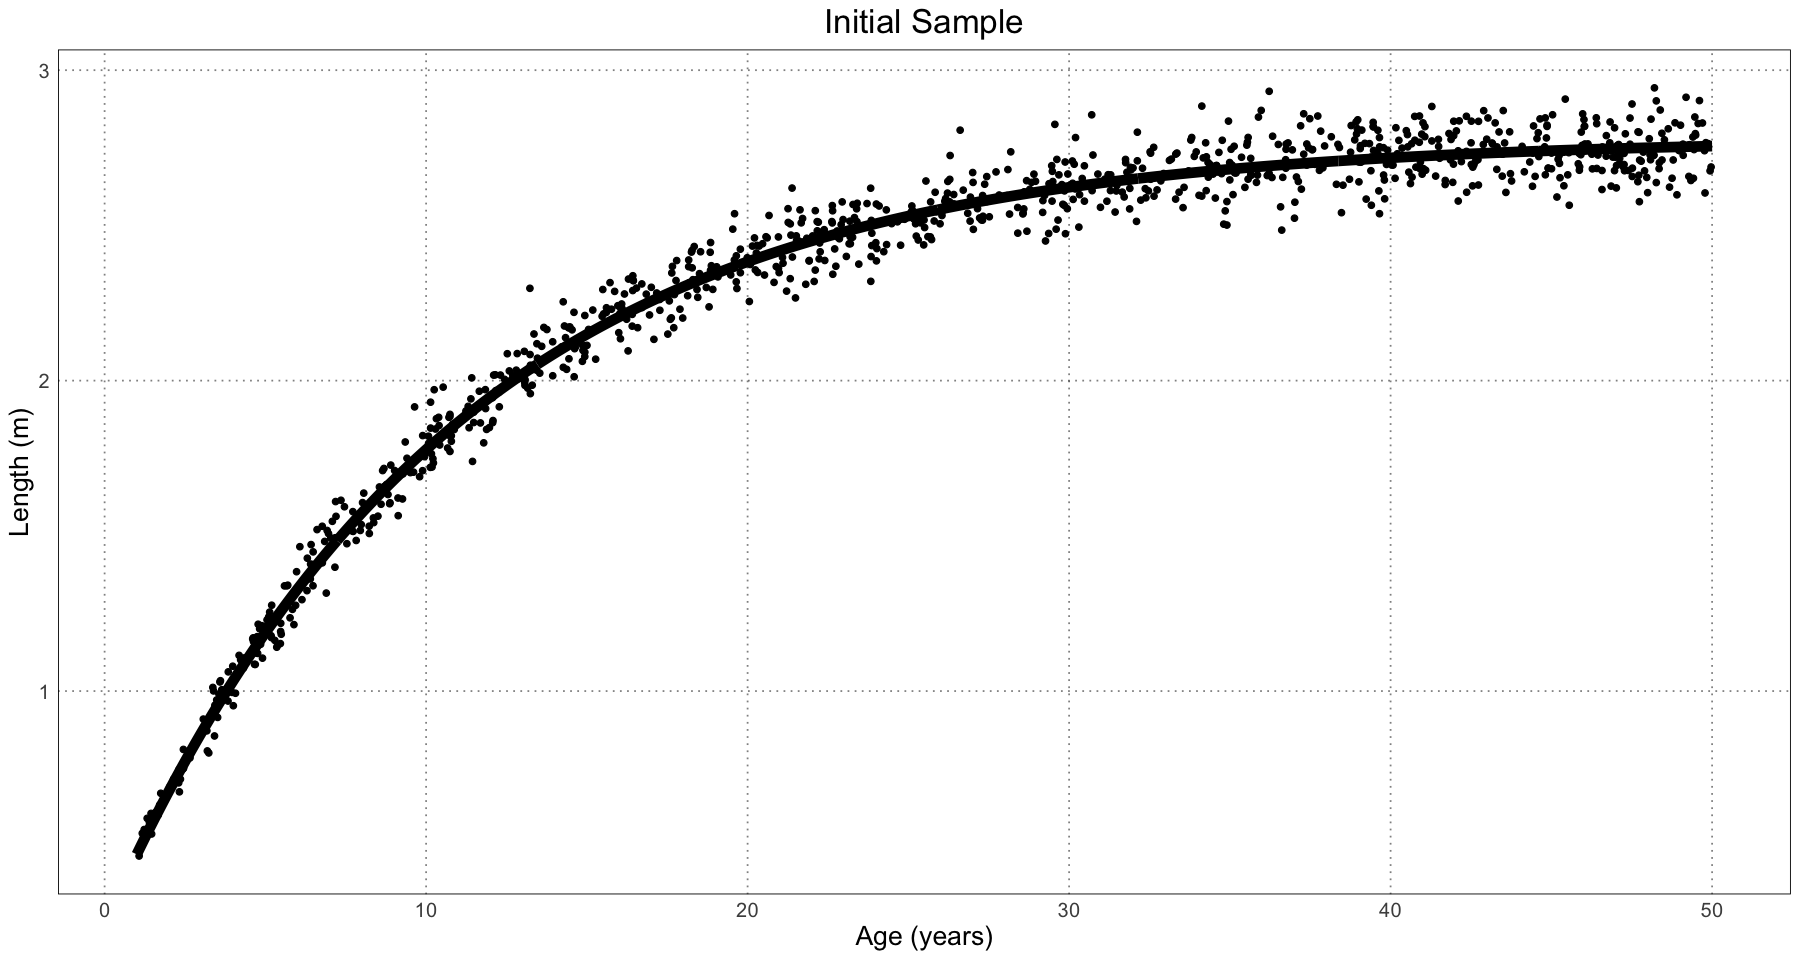

In [4]:
num_samples <- 1e3
ages <- runif(num_samples, 1, ALLIGATOR_MAX_LIFESPAN)
lengths <- generate_female_sample(ages)
sample_df <- data.frame(
    age = ages,
    length = lengths
)

curve_ages <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 1e3)
curve_lengths <- generalized_von_bertalanffy(curve_ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])
curve_df <- data.frame(
    age = curve_ages,
    length = curve_lengths
)
ggplot(sample_df, aes(age, length)) +
    custom_theme() +
    geom_line(data = curve_df, mapping = aes(age, length), linewidth = 3) +
    geom_point() +
    labs(x = "Age (years)", y = "Length (m)", title = "Initial Sample")

First, let's choose some priors. For that we need a model!

$$
\begin{align*}
L_i &\sim N(\mu_i, \sigma_i) \\
\mu_i &= \text{vonBertalanffy}(t_i, L, A, K) \\
\sigma_i &= \alpha \log(\mu_i) + \beta \\
L &\sim N(??, ??) \\
A &\sim N(??, ??) \\
K &\sim N(??, ??) \\
\alpha &\sim N(??, ??) \\
\beta &\sim N(??, ??) \\
\end{align*}
$$


In order to find our priors, we're going to simulate some curves and then take the 95% quantile of the generated values, and then basically just eyeball it until it looks ok.

Warning message in rnorm(length(curve_ages), mean = means, sd = sd):
“NAs produced”


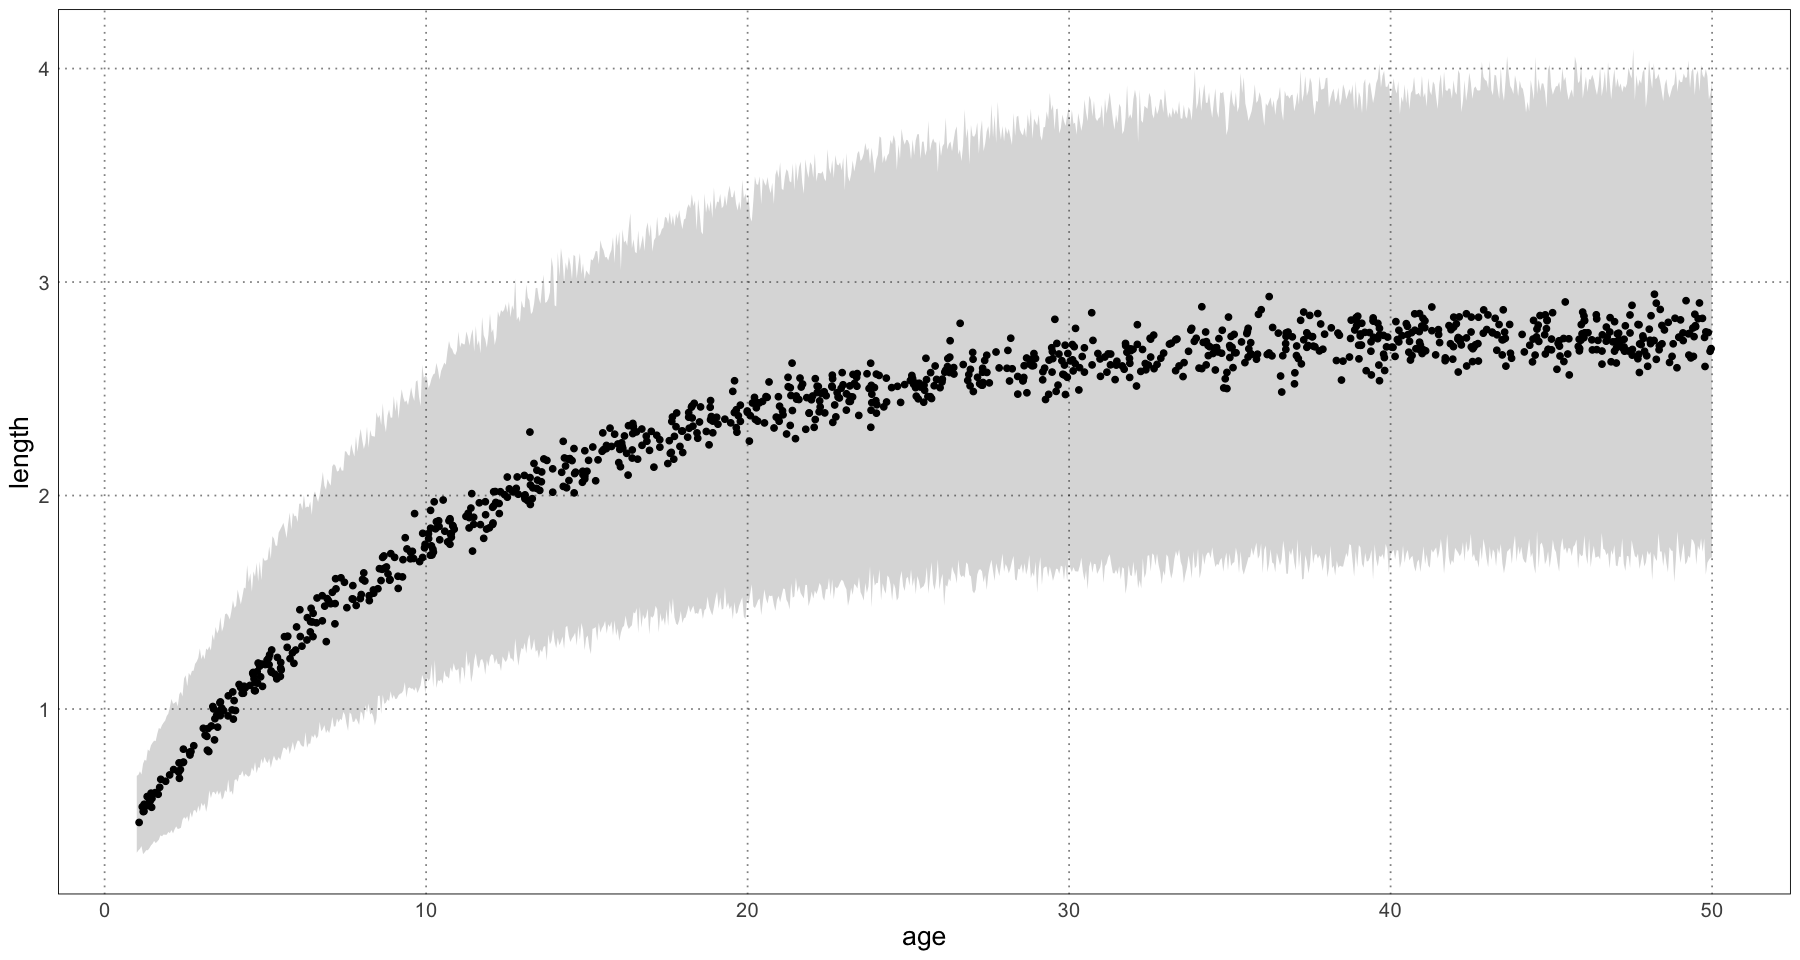

In [35]:
# prior means and standard deviations
prior_L <- c(actual_female_params[['L']], 0.5)
prior_A <- c(actual_female_params[['A']], 0.001)
prior_K <- c(actual_female_params[['K']], 0.001)
alpha <- sigma_coefficient
beta <- sigma_offset

prior_samples_df <- data.frame(
    age = numeric(),
    length = numeric()
)
for (i in 1:100) {
    L <- rnorm(1, prior_L[1], prior_L[2])
    A <- rnorm(1, prior_A[1], prior_A[2])
    K <- rnorm(1, prior_K[1], prior_K[2])

    means <- generalized_von_bertalanffy(curve_ages, L = L, A = A, K = K)
    sd <- alpha * log(means) + beta
    lengths <- rnorm(length(curve_ages), mean = means, sd = sd)
    prior_samples_df <- rbind(
        prior_samples_df,
        data.frame(
            age = curve_ages,
            length = lengths
        )
    )
    prior_samples_df <- prior_samples_df[!is.na(prior_samples_df$length), ]
}

significance_level <- 0.05
summary_df <- data.frame(age = numeric(), lower = numeric(), upper = numeric())
for (age in unique(curve_ages)) {
    relevant <- prior_samples_df[abs(prior_samples_df$age - age) < 0.0001, ]
    bounds <- quantile(relevant$length, c(alpha / 2, 1 - alpha / 2))
    summary_df <- rbind(summary_df, data.frame(
        age = age,
        lower = bounds[1],
        upper = bounds[2]
    ))
}
# summary_df
ggplot(summary_df, aes(x = age)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) +
    geom_point(data = sample_df, mapping = aes(age, length)) +
    custom_theme()


This seems OK. Obviously it's wrong, but at least we are in the right ballpark. We're going to lean on the data a bit to get us our actual values. Now let's fit the actual data!

In [39]:
von_bertalanffy_model <- "
functions {
    vector vonBertalanffy(vector age, real L, real A, real K) {
        int N = size(age);
        vector[N] means = L * (1 - A * exp(-K * age));
        return means;
    }
    vector orZero(vector v) {
        int N = size(v);
        vector[N] newV;
        for (i in 1:N) {
            if (v[i] <= 0) {
                newV[i] = 0;
            } else {
                newV[i] = v[i];
            }
        }
        return newV;
    }
}
data {
    // model data
    int<lower = 0> N; // number of samples
    vector<lower=0>[N] length; // a vector of the lengths
    vector<lower=0>[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])

    // prior data (mean and standard deviation)
    vector[2] prior_L;
    vector[2] prior_A;
    vector[2] prior_K;
    real alpha;
    real beta;
}

parameters {
    real<lower = 0> L;
    real A;
    real K;
}

model {
    vector[N] mean_length;
    vector[N] sd_length;

    L ~ normal(prior_L[1], prior_L[2]);
    K ~ normal(prior_K[1], prior_K[2]);
    A ~ normal(prior_A[1], prior_A[2]);
    mean_length = vonBertalanffy(age, L, A, K);
    sd_length = orZero(alpha * log(mean_length) + beta);
    length ~ normal(mean_length, sd_length);
}
"

In [40]:
data <- list(
    N = nrow(sample_df),
    age = sample_df$age,
    length = sample_df$length,
    prior_L = prior_L,
    prior_A = prior_A,
    prior_K = prior_K,
    alpha = alpha,
    beta = beta
)
model.single_vb <- stan(model_code = von_bertalanffy_model, data = data, iter = 8000)
model.single_vb

Inference for Stan model: anon_model.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

        mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
L       2.78    0.00 0.00    2.77    2.78    2.78    2.78    2.79  5830    1
A       0.91    0.00 0.00    0.91    0.91    0.91    0.91    0.91  8226    1
K       0.09    0.00 0.00    0.09    0.09    0.09    0.09    0.09  7443    1
lp__ 2175.88    0.02 1.21 2172.77 2175.33 2176.18 2176.77 2177.26  6123    1

Samples were drawn using NUTS(diag_e) at Fri Feb  9 06:16:26 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

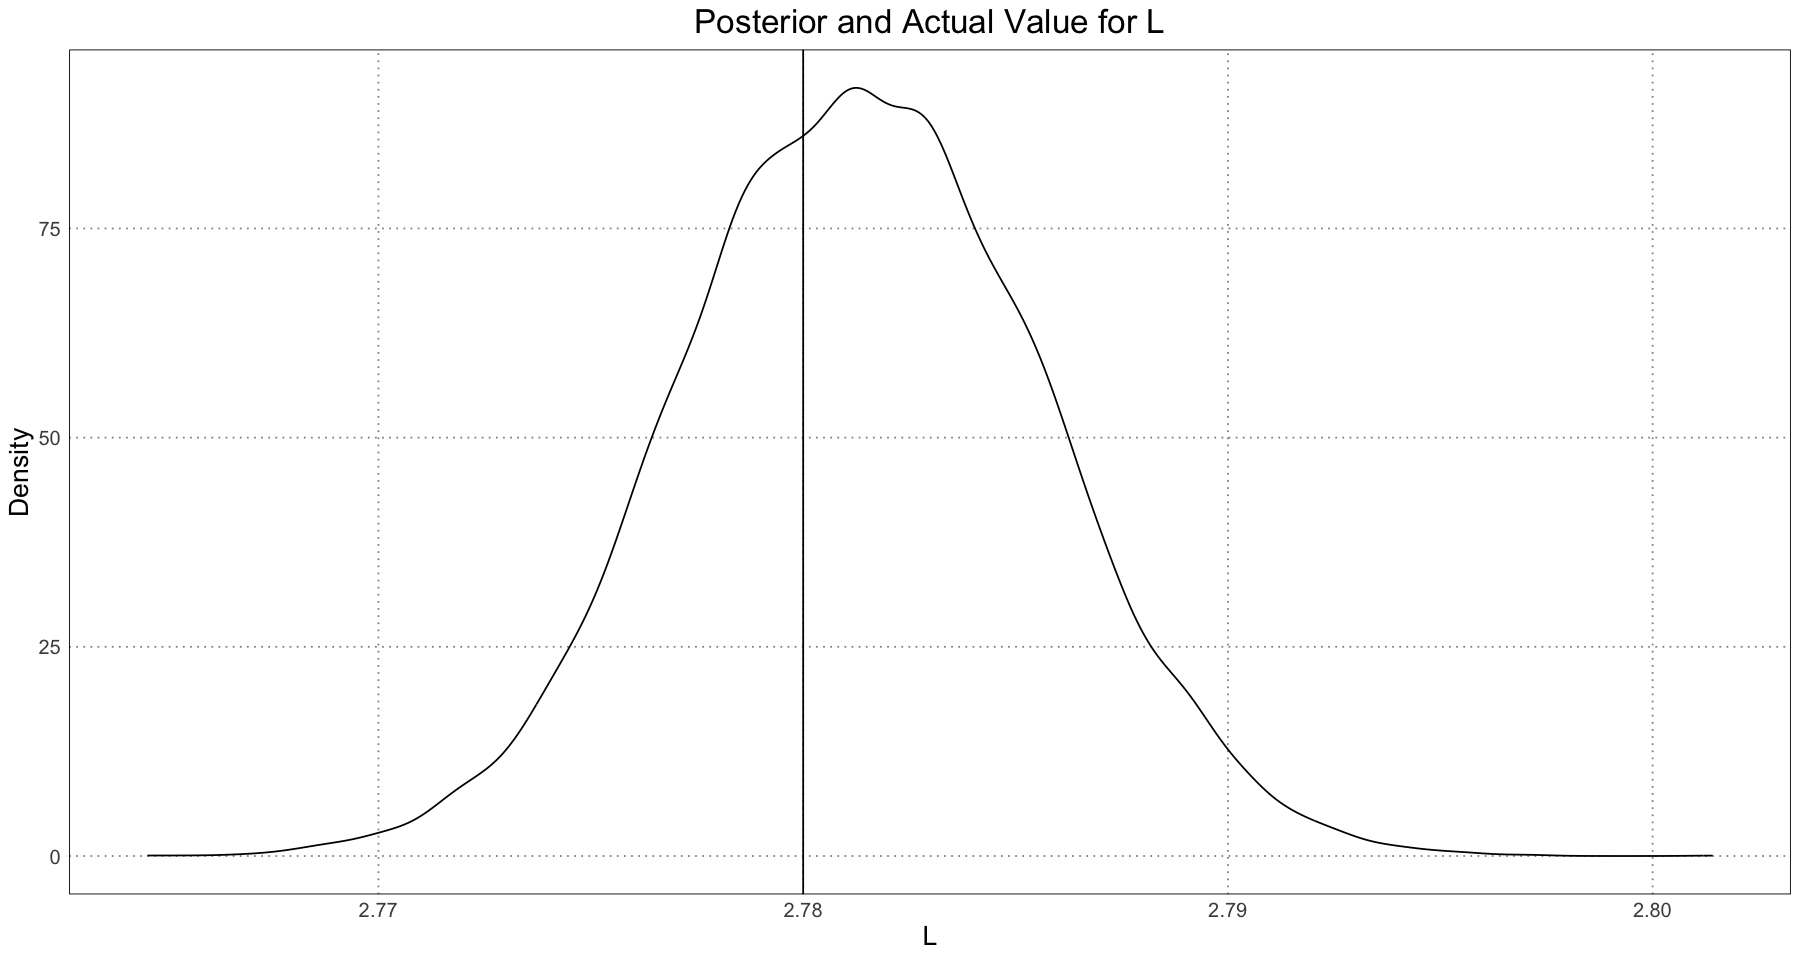

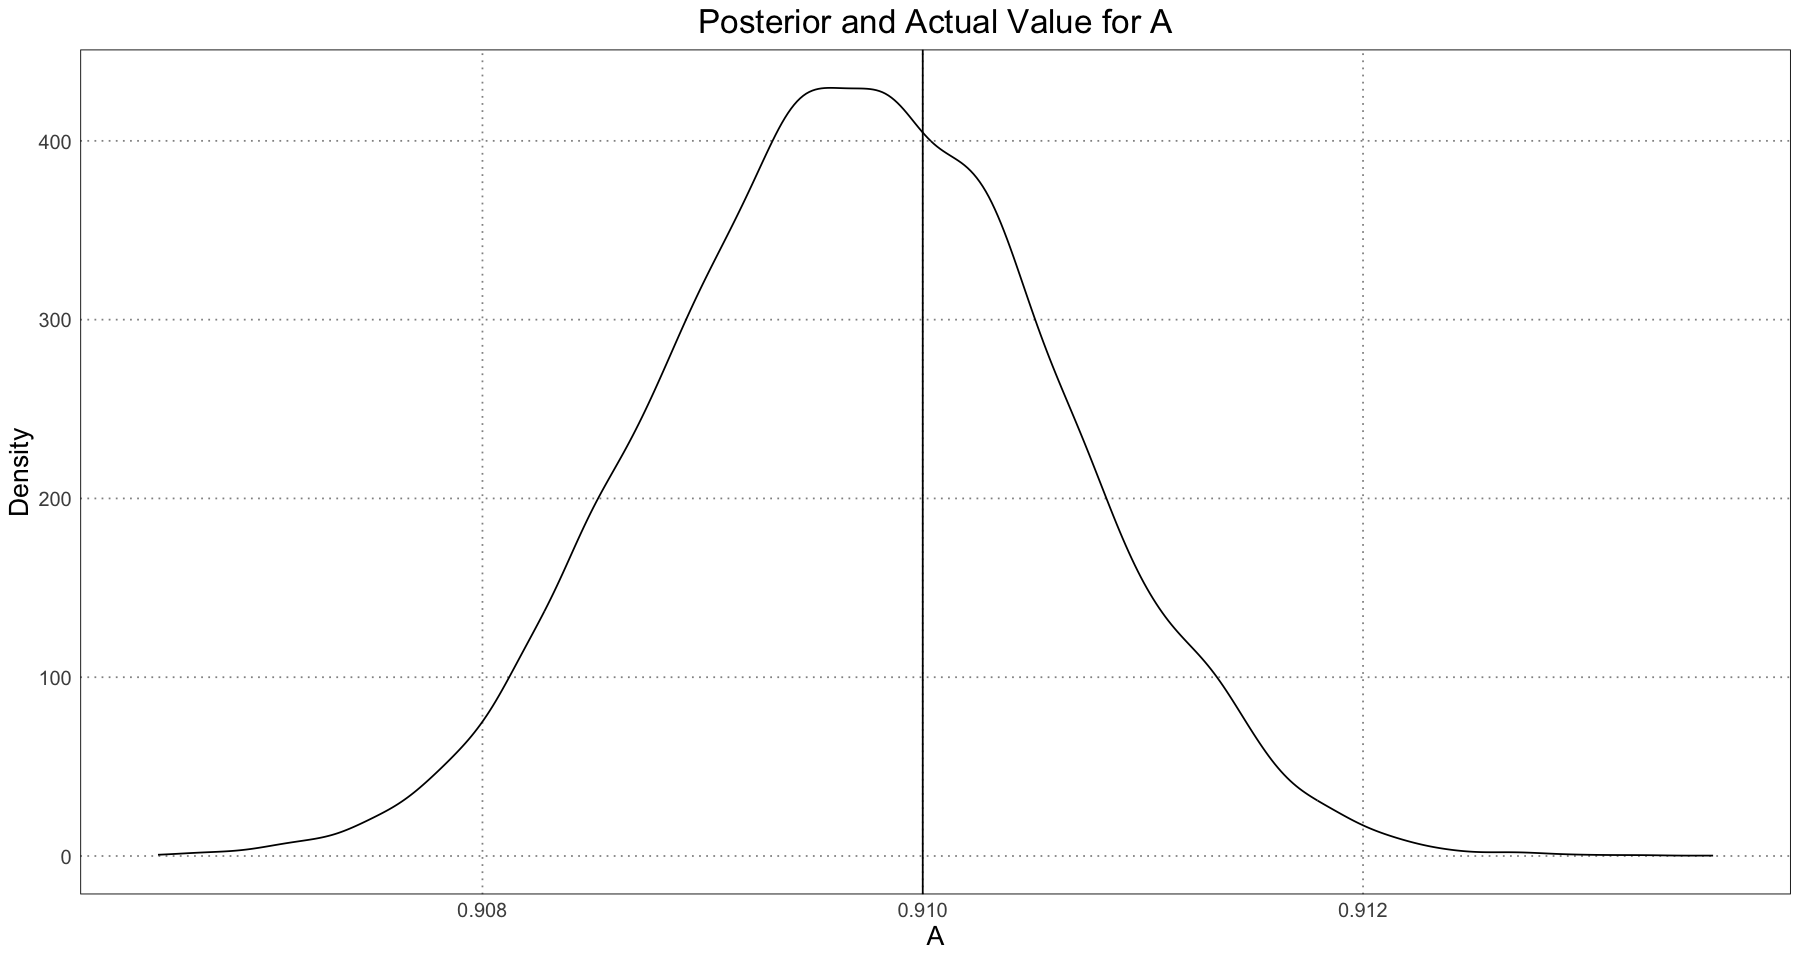

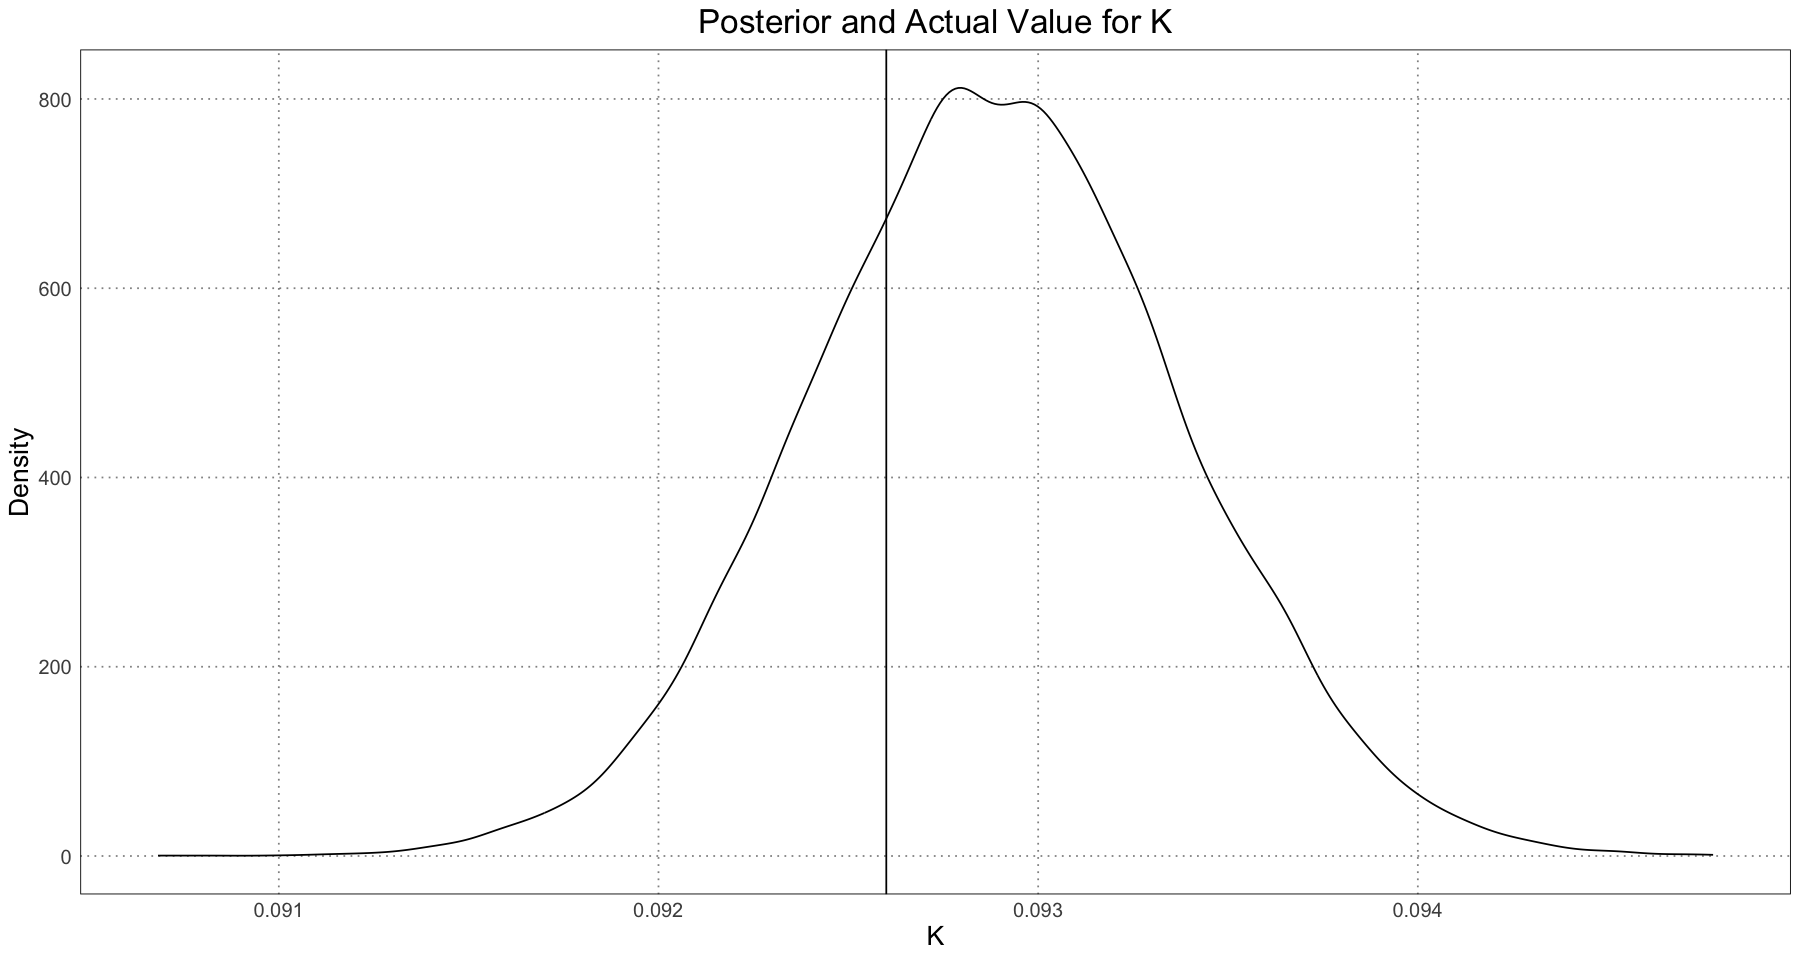

In [43]:
samples <- extract(model.single_vb)

for (param in c('L', 'A', 'K')) {
    df <- data.frame(x = samples[[param]])
    p <- ggplot(df, aes(x)) +
        custom_theme() +
        geom_density(aes(y = after_stat(density))) +
        geom_vline(xintercept = actual_female_params[[param]]) +
        labs(x = param, y = "Density", title = paste("Posterior and Actual Value for", param))
    print(p)
}
# df <- data.frame(x = samples[['alpha']])
# p <- ggplot(df, aes(x)) +
#     geom_density(aes(y = after_stat(density))) +
#     geom_vline(xintercept = sigma_coefficient)
# print(p)
# df <- data.frame(x = samples[['beta']])
# p <- ggplot(df, aes(x)) +
#     geom_density(aes(y = after_stat(density))) +
#     geom_vline(xintercept = sigma_offset)
# print(p)

## Analysis Sensitivity to Sample Size

Of course, this result was with an unreasonably large sample size. What happens when we run the same model, but with smaller sample sizes? For this we'll concentrate on the effect on the $L$ parameter, since that's the one that we are relying on most heavily for the analysis.

In [62]:
sample_size_df <- data.frame(
    sample_size = numeric(),
    L = numeric()
)
sample_sizes <- c(2, 5, 10, 50, 100)
for (sample_size in sample_sizes) {
    sample_ages <- runif(sample_size, 1, ALLIGATOR_MAX_LIFESPAN)
    sample_lengths <- generate_female_sample(sample_ages)
    data <- list(
        N = length(sample_ages),
        age = sample_ages,
        length = sample_lengths,
        prior_L = prior_L,
        prior_A = prior_A,
        prior_K = prior_K,
        alpha = alpha,
        beta = beta
    )
    sample_size_model <- stan(model_code = von_bertalanffy_model, data = data, iter = 8000)
    samples <- extract(sample_size_model)
    sample_size_df <- rbind(
        sample_size_df,
        data.frame(sample_size = sample_size, L = samples[['L']])
    )
}
head(sample_size_df)

,sample_size,L
,<dbl>,<dbl>
1,2,2.831317
2,2,2.790134
3,2,2.687021
4,2,2.736505
5,2,2.788423
6,2,2.657007


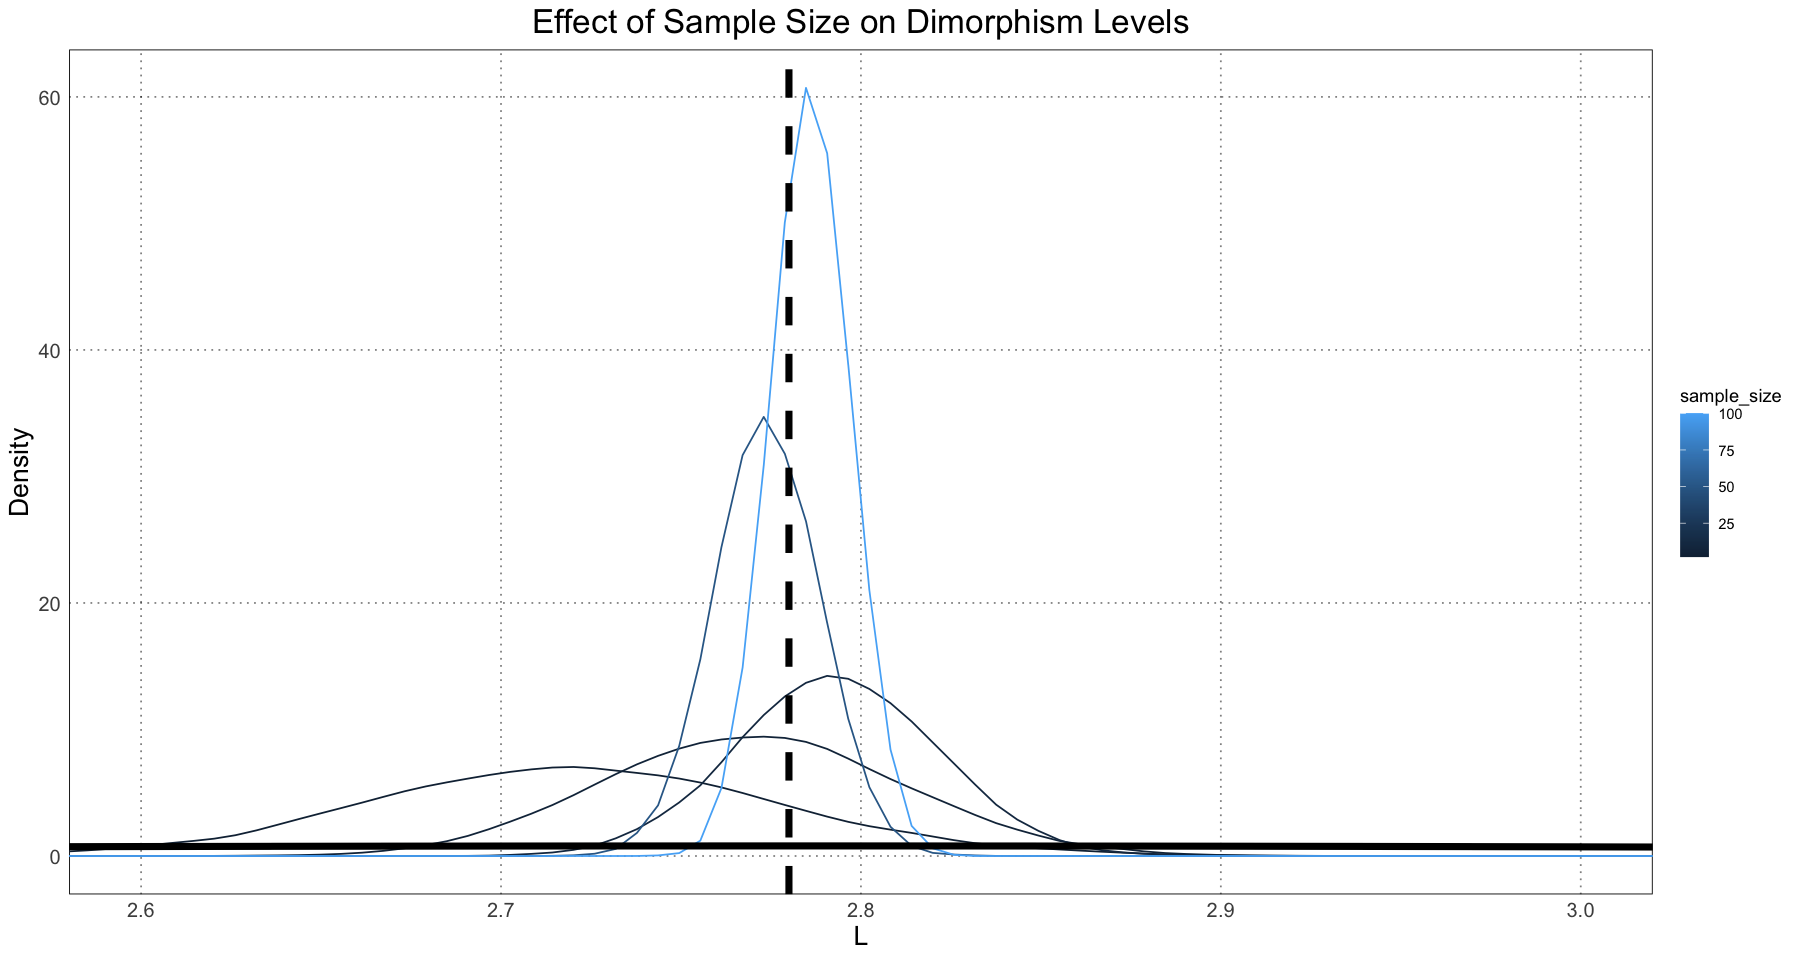

In [66]:
prior_support <- seq(1, 4, length.out = 100)
prior_density <- dnorm(prior_support, mean = prior_L[1], sd = prior_L[2])
prior_df <- data.frame(x = prior_support, y = prior_density)

ggplot() +
    geom_density(data = sample_size_df, mapping = aes(L, after_stat(density), colour = sample_size, group = sample_size)) +
    geom_line(data = prior_df, mapping = aes(x, y), linewidth = 2) +
    geom_vline(xintercept = actual_female_params[['L']], linewidth = 2, linetype = 'dashed') +
    coord_cartesian(xlim = c(2.6, 3)) +
    custom_theme() +
    labs(x = "L", y = "Density", title = "Effect of Sample Size on Dimorphism Levels")

We can also look at this another way.

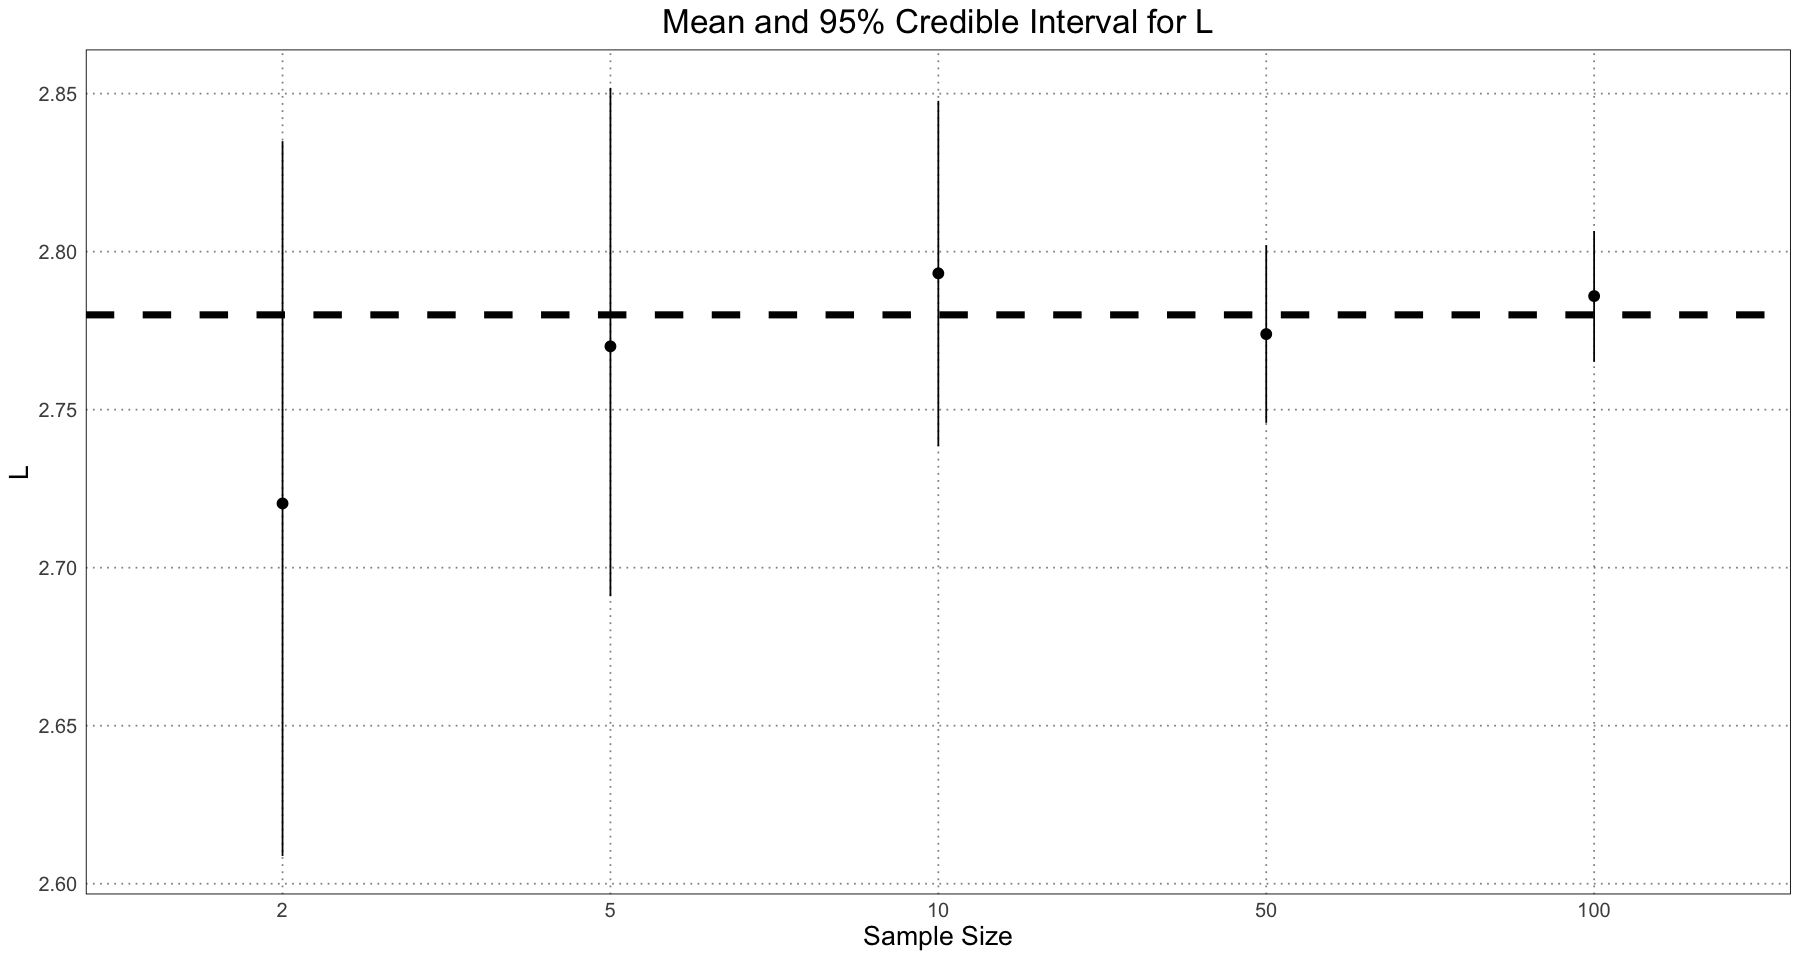

In [73]:
alternate_sample_size_df <- data.frame(
    sample_size = integer(),
    mean = numeric(),
    lower = numeric(),
    upper = numeric()
)
significance_alpha <- 0.05
for (sample_size in sample_sizes) {
    relevant <- sample_size_df[sample_size_df$sample_size == sample_size, ]
    sample_mean <- mean(relevant$L)
    bounds <- quantile(relevant$L, c(significance_alpha / 2, 1 - significance_alpha / 2))
    alternate_sample_size_df <- rbind(
        alternate_sample_size_df,
        data.frame(
            sample_size = sample_size,
            mean = sample_mean,
            lower = bounds[1],
            upper = bounds[2]
        )
    )
}
alternate_sample_size_df$sample_size <- factor(alternate_sample_size_df$sample_size)
ggplot(alternate_sample_size_df, aes(sample_size, mean)) +
    geom_pointrange(aes(ymin = lower, ymax = upper)) +
    geom_hline(yintercept = actual_female_params[['L']], linewidth = 2, linetype = 'dashed') +
    custom_theme() +
    labs(x = "Sample Size", y = "L", title = "Mean and 95% Credible Interval for L")

## Recovering Dimorphism

OK, now let's add the fact that we're looking at two different sexes with their own growth curves. Just like in the paper, we're going to assume they have the same standard deviation.

In [74]:
generate_male_sample <- function(ages) {
    means <- generalized_von_bertalanffy(age = ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
    sd <- sigma_coefficient * log(means) + sigma_offset
    rnorm(length(ages), mean = means, sd = sd)
}

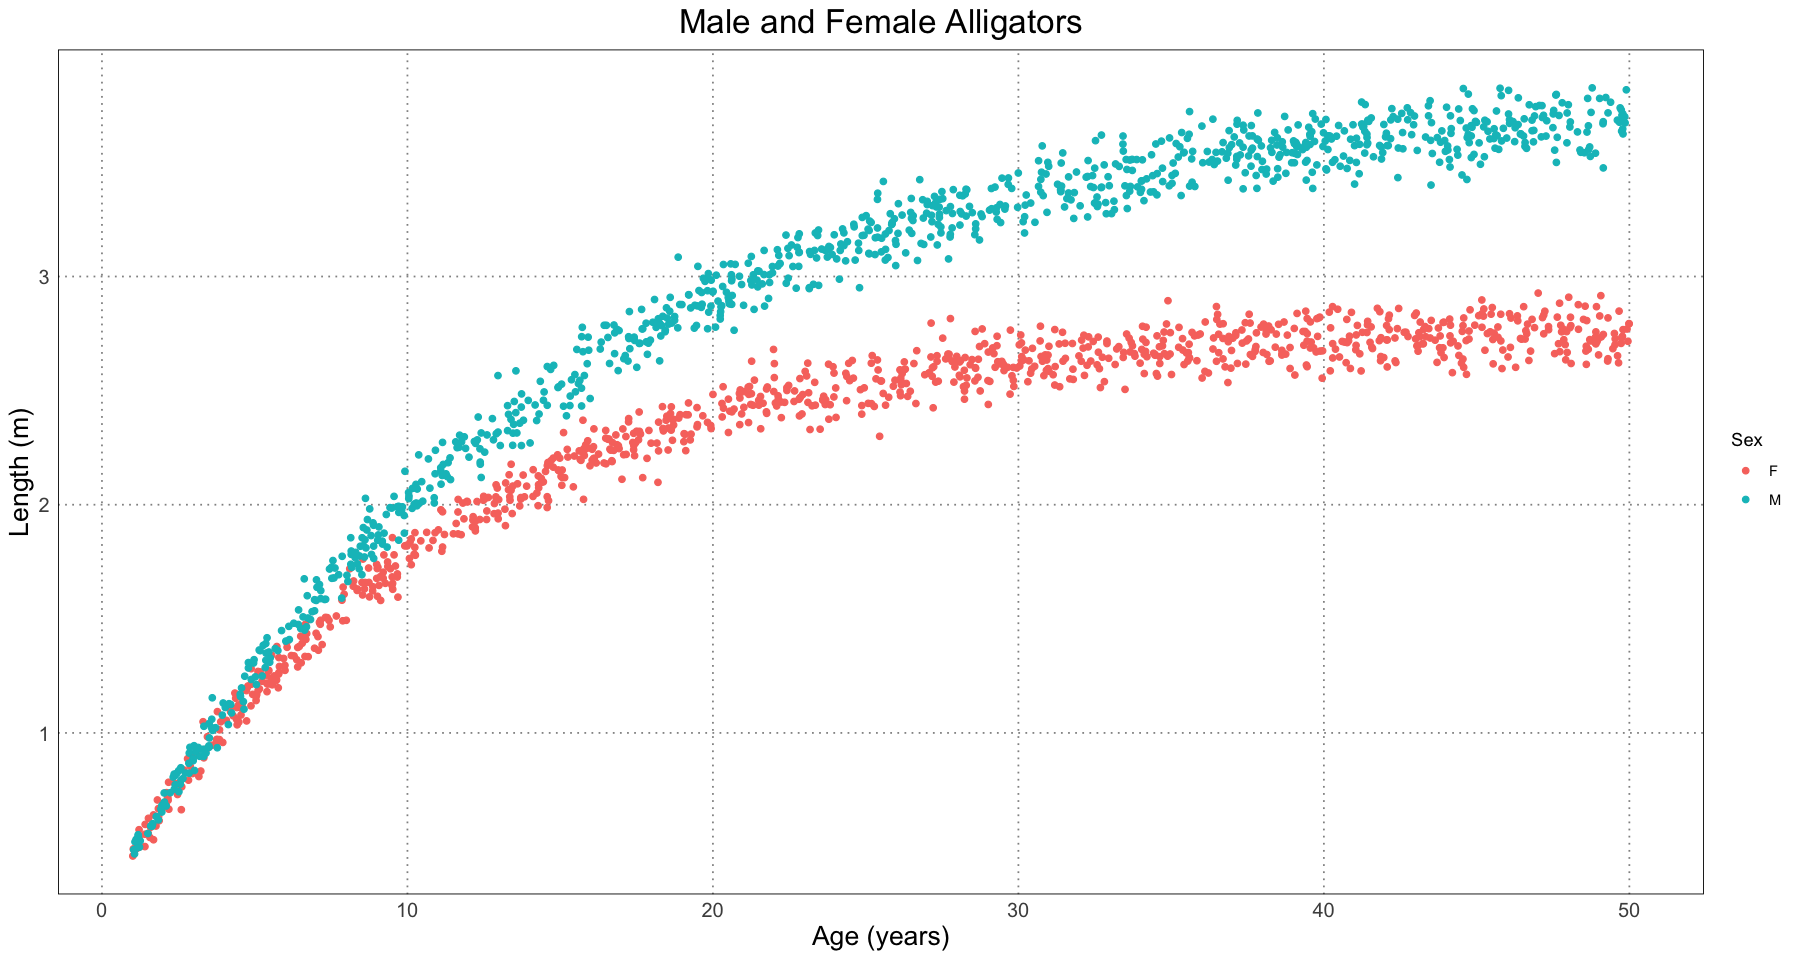

In [77]:
num_samples <- 1e3
female_sample_ages <- runif(num_samples, 1, ALLIGATOR_MAX_LIFESPAN)
female_lengths <- generate_female_sample(female_sample_ages)
male_sample_ages <- runif(num_samples, 1, ALLIGATOR_MAX_LIFESPAN)
male_lengths <- generate_male_sample(male_sample_ages)

combined_data <- data.frame(
    age = c(female_sample_ages, male_sample_ages),
    length = c(female_lengths, male_lengths),
    sex = rep(c("F", "M"), each = num_samples)
)

ggplot(combined_data, aes(age, length, colour = sex, group = sex)) +
    geom_point() +
    custom_theme() +
    labs(x = "Age (years)", y = "Length (m)", title = "Male and Female Alligators", colour = "Sex")

In [ ]:
NEXT STEPS: 
 - function to predict
 - create the dimorphism stan model
 - See how the dimorphism relates to the actual level
 - compute over many effect sizes
 - See how this is affected by the accuracy of sex determination